/home/ardie85/PHD/Research/code/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


Episode 0 - Action from Problem Solver
Episode 0 - Action from Problem Solver
agent 0 old state: tensor([-0.9000,  0.9000,  0.0000,  0.0000,  0.0000, -0.8000,  0.0000],
       device='cuda:0')
agent 0 action: tensor([[[1.7872e-02, 3.2187e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.9000e+01, 9.9000e+01, 1.7872e-02, 3.2187e-01, 0.0000e+00,
          0.0000e+00]]], device='cuda:0', dtype=torch.float64)
agent 0 reward: tensor([0.0006], device='cuda:0')
agent 0 new state: tensor([-9.0020e-01,  8.9918e-01, -2.7141e-03, -1.0909e-02,  0.0000e+00,
        -8.0000e-01,  9.9000e+01,  9.9000e+01,  1.7872e-02,  3.2187e-01,
         0.0000e+00,  0.0000e+00], device='cuda:0', dtype=torch.float64)
agent 1 old state: tensor([ 0.9000,  0.9000,  0.0000,  0.0000,  0.0000, -0.8000,  0.0000],
       device='cuda:0')
agent 1 action: tensor([[[1.7872e-02, 3.2187e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.9000e+01, 9.9000e+01, 1.7872e-02, 3.2187e

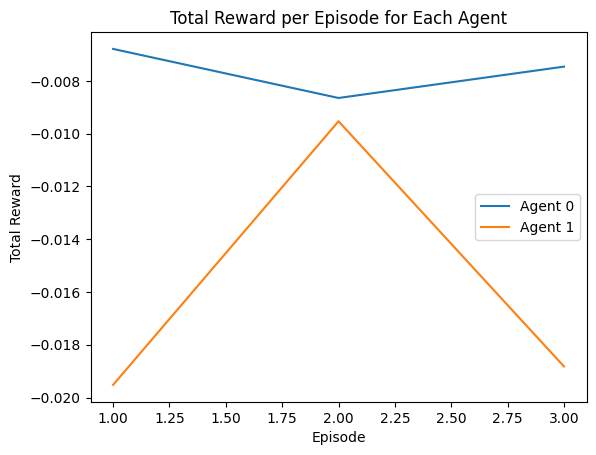

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


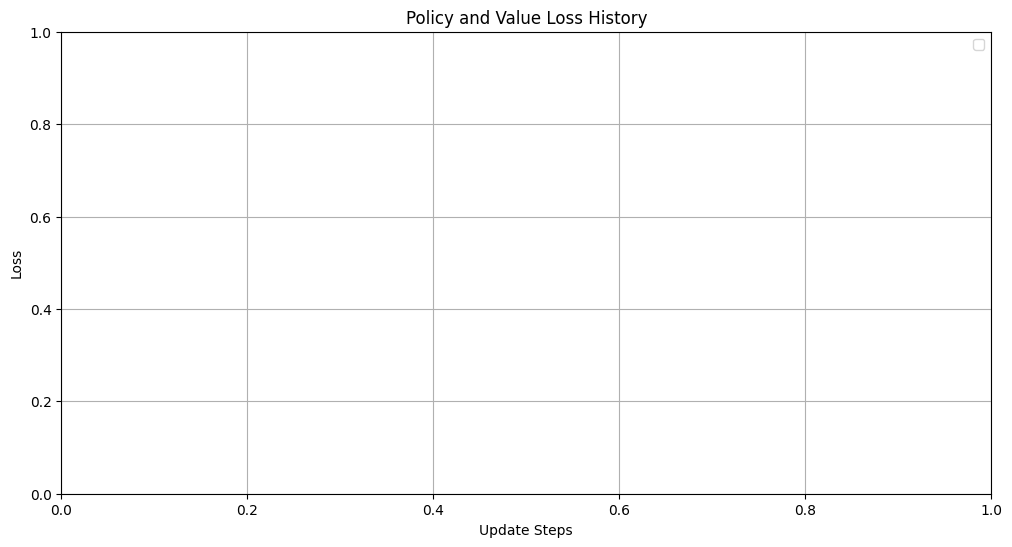

MoviePy - Building file navigation_comm.gif with imageio.


In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import json
import ast
from vmas import make_env
from vmas.simulator.core import Agent
from vmas.simulator.scenario import BaseScenario
from typing import Union
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML, display as ipython_display
import numpy as np
import matplotlib.pyplot as plt
from gym.spaces import Discrete
import math
from collections import deque, defaultdict

# Actor-Critic Neural Network for PPO
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )


    def forward(self, x):
        value = self.critic(x)
        policy_dist = torch.tanh(self.actor(x))
        rounded_policy_dist = self.round_actions(policy_dist, decimal_places=2)
        return rounded_policy_dist, value

    def round_actions(self, actions, decimal_places=3):
        scale_factor = 10 ** decimal_places
        return torch.round(actions * scale_factor) / scale_factor


# PPO Buffer to store trajectories
class PPOBuffer:
    def __init__(self, state_dim, action_dim, size, device):
        self.states = torch.zeros(size, state_dim, device=device)
        self.actions = torch.zeros(size, action_dim, device=device)
        self.rewards = torch.zeros(size, device=device)
        self.next_states = torch.zeros(size, state_dim, device=device)
        self.log_probs = torch.zeros(size, device=device)
        self.values = torch.zeros(size, device=device)
        self.advantages = torch.zeros(size, device=device)
        self.returns = torch.zeros(size, device=device)
        self.pointer = 0
        self.max_size = size
        self.device = device

    def store(self, state, action, reward, next_state, log_prob, value):
        # print(f"Buffer pointer before storing: {self.pointer}")
        idx = self.pointer
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state

        if log_prob is not None:
            self.log_probs[idx] = log_prob
        if value is not None:
            self.values[idx] = value

        self.pointer += 1
        # print(f"Buffer pointer after storing: {self.pointer}")



    def finish_path(self, last_value, gamma, lam):
        path_slice = slice(0, self.pointer)
        rewards = torch.cat([self.rewards[path_slice], last_value.unsqueeze(0)], dim=0)
        values = torch.cat([self.values[path_slice], last_value.unsqueeze(0)], dim=0)
        deltas = rewards[:-1] + gamma * values[1:] - values[:-1]
        self.advantages[path_slice] = self.discount_cumsum(deltas, lam * gamma)
        self.returns[path_slice] = self.discount_cumsum(rewards, gamma)[:-1]

    def discount_cumsum(self, x, discount):
        return torch.flip(torch.cumsum(torch.flip(x, dims=[0]) * discount, dim=0), dims=[0])

    def get(self):
        # Retrieve data up to the current pointer position
        states = self.states[:self.pointer]
        actions = self.actions[:self.pointer]
        log_probs = self.log_probs[:self.pointer]
        advantages = self.advantages[:self.pointer]
        returns = self.returns[:self.pointer]

        # Reset the pointer for the next batch of data
        self.pointer = 0
        
        return states, actions, log_probs, advantages, returns



# Problem Solver class for PPO
class ProblemSolver:
    def __init__(self, env, agent_id, state_dim, action_dim, device, alpha=0.1, gamma=0.99, epsilon=0.2, K_epochs=4, batch_size=64, communication_weight=0.5):
        self.buffer = PPOBuffer(state_dim, action_dim, size=1000, device=device)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.K_epoch = K_epochs
        self.batch_size = batch_size
        self.env = env
        self.agent_id = agent_id
        self.device = device

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=alpha)
        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.policy_loss_history = []
        self.value_loss_history = []

    def get_action_continuous(self, agent_obs):
        state = torch.Tensor(agent_obs[:6]).to(self.device) if not isinstance(agent_obs[:6], torch.Tensor) else agent_obs[:6].to(self.device)
        state = state.float()
        
        with torch.no_grad():
            policy_dist, value = self.policy_old(state)
        
        # Assuming Gaussian policy for continuous action space
        dist = torch.distributions.Normal(policy_dist, torch.ones_like(policy_dist) * 0.1)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)  # Sum over actions if multiple
        
        return action.cpu().numpy(), log_prob, value


    def update_action_continuous(self):
        if self.buffer.pointer < self.batch_size:
            return  # Not enough data to perform an update

        states, actions, log_probs, advantages, returns = self.buffer.get()

        for _ in range(self.K_epoch):
            # Calculate new log probabilities and state values
            new_log_probs, state_values = self.policy(states)
            
            # Sum the log probabilities over the action dimension to reduce to 1D
            new_log_probs = new_log_probs.sum(dim=-1)

            # Now the shapes should match, and ratios can be computed
            ratios = torch.exp(new_log_probs - log_probs)

            # Calculate the policy loss using the clipped surrogate objective
            surrogate1 = ratios * advantages
            surrogate2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantages
            policy_loss = -torch.min(surrogate1, surrogate2).mean()

            # Calculate the value loss
            value_loss = (returns - state_values).pow(2).mean()

            # Store the losses for later plotting
            self.policy_loss_history.append(policy_loss.item())
            self.value_loss_history.append(value_loss.item())

            # Total loss and backpropagation
            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()



            print("Network Updated!")



    def store_in_buffer(self, state, action, reward, next_state, log_prob, value):
        if isinstance(state, np.ndarray):
            state = torch.tensor(state, device=self.device, dtype=torch.float32)
        if isinstance(action, np.ndarray):
            action = torch.tensor(action, device=self.device, dtype=torch.float32)
        if isinstance(next_state, np.ndarray):
            next_state = torch.tensor(next_state, device=self.device, dtype=torch.float32)
        if isinstance(reward, (float, int)):
            reward = torch.tensor(reward, device=self.device, dtype=torch.float32)

        # Ensure log_prob is consistent with new_log_probs by summing if necessary
        if log_prob is not None and len(log_prob.shape) > 1:
            log_prob = log_prob.sum(dim=-1)

        self.buffer.store(state, action, reward, next_state, log_prob, value)





    def finish_path(self, last_value):
        self.buffer.finish_path(last_value, self.gamma, lam=0.95)


# Case-Based Reasoning class
class Case:
    added_states = set()

    def __init__(self, problem, solution, reward, trust_value=1):
        self.problem = problem
        self.solution = solution
        self.reward = reward
        self.trust_value = trust_value

    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)
        state2 = np.atleast_1d(state2)
        CNDMaxDist = 6
        v = state1.size
        DistQ = np.sum([Case.dist_q(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def dist_q(X1, X2):
        return np.min(np.abs(X1 - X2))

    @staticmethod
    def retrieve(agent, env, state, case_base, threshold=0.1):
        if isinstance(state, torch.Tensor):
            state = state.cpu().numpy()

        state_list = state.tolist() if isinstance(state, np.ndarray) else state
        state_str = json.dumps(state_list)
        state = ast.literal_eval(state_str)

        similarities = {}
        for case in case_base:
            problem_numeric = np.array(case.problem, dtype=float)
            state_numeric = np.array(state, dtype=float)
            similarities[case] = Case.sim_q(state_numeric, problem_numeric)

        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

        if sorted_similarities:
            most_similar_case = sorted_similarities[0][0] if sorted_similarities[0][1] >= threshold else None
        else:
            most_similar_case = None

        return most_similar_case

    @staticmethod
    def reuse(c, temporary_case_base):
        temporary_case_base.append(c)

    @staticmethod
    def revise(case_base, temporary_case_base, successful_task):
        for case in temporary_case_base:
            if successful_task and case in case_base:
                case.trust_value += 0.1
            elif not successful_task and case in case_base:
                case.trust_value -= 0.1
            case.trust_value = max(0, min(case.trust_value, 1))

    @staticmethod
    def retain(case_base, temporary_case_base, successful_task, threshold=0.7):
        if successful_task:
            aggregation_dict = defaultdict(lambda: {'x_velocity_sum': 0, 'y_velocity_sum': 0, 'reward_sum': 0, 'count': 0})
            for case in temporary_case_base:
                state = tuple(np.atleast_1d(case.problem))
                aggregation_dict[state]['x_velocity_sum'] += case.solution[0]
                aggregation_dict[state]['y_velocity_sum'] += case.solution[1]
                aggregation_dict[state]['reward_sum'] += case.reward
                aggregation_dict[state]['count'] += 1
            
            for state, values in aggregation_dict.items():
                aggregated_case = Case(
                    problem=state,
                    solution=[values['x_velocity_sum'] / values['count'], values['y_velocity_sum'] / values['count']],
                    reward=values['reward_sum'] / values['count'],
                    trust_value=np.nan
                )
                if state not in Case.added_states:
                    case_base.append(aggregated_case)
                    Case.added_states.add(state)
                else:
                    existing_index = next((i for i, c in enumerate(case_base) if tuple(np.atleast_1d(c.problem)) == state), None)
                    if existing_index is not None:
                        existing_case = case_base[existing_index]
                        existing_case.solution = aggregated_case.solution
                        existing_case.reward = aggregated_case.reward
                        existing_case.trust_value = np.nan
        case_base = [case for case in case_base if case.trust_value >= threshold]
        return case_base


# Main runner for VMAS environment
class QCBRLVmasRunner:
    def __init__(
        self,
        render: bool,
        num_envs: int,
        num_episodes: int,
        max_steps_per_episode: int,
        device: str,
        scenario: Union[str, BaseScenario],
        continuous_actions: bool,
        random_action: bool,
        n_agents: int,
        obs_discrete: bool = False,
        **kwargs
    ):
        self.render = render
        self.num_envs = num_envs
        self.num_episodes = num_episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.device = device
        self.scenario = scenario
        self.continuous_actions = continuous_actions
        self.random_action = random_action
        self.obs_discrete = obs_discrete
        self.kwargs = kwargs
        self.frame_list = []
        self.problem_solver_agents = []
        self.rewards_history = []
        self.action_counts = {i: {} for i in range(n_agents)}
        self.agent_rewards_history = {i: [] for i in range(n_agents)}
        self.successful_episodes_individual = {i: 0 for i in range(n_agents)}
        self.successful_episodes_all_agents = 0
        self.case_base = {i: [] for i in range(n_agents)}
        self.temporary_case_base = {i: [] for i in range(n_agents)}

    def get_distance_category(self, distance):
        if distance == 0:
            distance_qualitative = 0 #at
        elif distance < 0.1:
            distance_qualitative = 1 #very close
        elif distance < 0.25:
            distance_qualitative = 2 #close
        elif distance < 0.5:
            distance_qualitative = 3 #far
        elif distance < 75:
            distance_qualitative = 4 #very far
        else:
            distance_qualitative = 5 #farthest
        return distance_qualitative
        
    def get_direction_category(self, agent_x, agent_y, target_x, target_y):
        dx = target_x - agent_x
        dy = target_y - agent_y

        if dy > 0:
            if dx > 0:
                direction_qualitative = 1 #top right
            elif dx < 0:
                direction_qualitative = 2 #top left
            else:
                direction_qualitative = 3 #top
        elif dy < 0:
            if dx > 0:
                direction_qualitative = 4 #bottom right
            elif dx < 0:
                direction_qualitative = 5 #bottom left
            else:
                direction_qualitative = 6 #bottom
        else:
            if dx > 0:
                direction_qualitative = 7 #right
            elif dx < 0:
                direction_qualitative = 8 #left
            else:
                direction_qualitative = 0 #at
            
        return direction_qualitative

    def _get_qualitative_position(self, env, observation):
        pos_x = observation[0:1]
        pos_y = observation[1:2]
        goal_x = observation[4:5]
        goal_y = observation[5:6]    

        distance = math.sqrt((goal_x - pos_x)**2 + (goal_y - pos_y)**2) #Euclidean distance
        distance_category = self.get_distance_category(distance)
        direction_category = self.get_direction_category(pos_x, pos_y, goal_x, goal_y)
      
        return distance_category, direction_category

    def _get_action(self, agent, env, agent_id, obs_qualitative, obs_quantitative, device, episode):
        physical_action = []
        comm_action_length = 4

        case = Case.retrieve(agent, env, obs_qualitative, self.case_base[agent_id], threshold=0.1)
                        
        if case:
            physical_action = case.solution
            log_prob, value = None, None  # No log_prob or value for case-based actions
            print(f"Episode {episode} - Action from Case Base")
        else:    
            physical_obs_quantitative = obs_quantitative[0:6]

            if self.continuous_actions:
                physical_action, log_prob, value = self.problem_solver_agents[agent_id].get_action_continuous(physical_obs_quantitative)
                if isinstance(physical_action, np.ndarray):
                    physical_action = torch.tensor(physical_action, device=self.device, dtype=torch.float32)
                
                # Store valid data in the buffer
                if log_prob is not None and value is not None:
                    self.problem_solver_agents[agent_id].store_in_buffer(physical_obs_quantitative, physical_action, log_prob, value, None, None)
            else:
                physical_action = self.problem_solver_agents[agent_id].get_action_discrete(agent, env, agent_id, physical_obs_quantitative, device)
                log_prob, value = None, None  # No log_prob or value for discrete actions
                

            print(f"Episode {episode} - Action from Problem Solver")
        
        
        physical_action_tensor = torch.tensor(physical_action, device=self.device)
        zero_tensor = torch.zeros(comm_action_length, dtype=torch.float64, device=self.device)
        physical_action_tensor_padded = torch.cat((physical_action_tensor, zero_tensor))

        if agent.silent:
            action = physical_action_tensor_padded
        else:
            if not case:
                obs_qualitative_tensor = torch.tensor([float(99), float(99)], device=self.device)
                reward_tensor = torch.tensor([float(0)], device=self.device)
                trust_value_tensor = torch.tensor([float(0)], device=self.device)
            else:  
                obs_qualitative_tensor = torch.tensor(case.problem, device=self.device)
                reward_tensor = torch.tensor(case.reward, device=self.device)
                trust_value_tensor = torch.tensor(case.trust_value, device=self.device)

            comm_action_tensor = torch.cat([obs_qualitative_tensor, physical_action_tensor, reward_tensor, trust_value_tensor], dim=0)
            action = torch.stack((physical_action_tensor_padded, comm_action_tensor)).unsqueeze(0)

        # Store in buffer only if log_prob and value are not None
        if log_prob is not None and value is not None:
            self.problem_solver_agents[agent_id].store_in_buffer(physical_obs_quantitative, physical_action, log_prob, value, None, None)

        return action

    def save_case_base(self, agent_id):
        filename = f"cases/case_base_{agent_id}.json"
        case_base_data = []
        for case in self.case_base[agent_id]:
            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            if torch.is_tensor(case.solution):
                solution = case.solution.tolist() if case.solution.numel() > 1 else int(case.solution.item())
            else:
                solution = int(case.solution)
            
            if torch.is_tensor(case.reward):
                reward = case.reward.tolist() if case.reward.numel() > 1 else float(case.reward.item())
            else:
                reward = float(case.reward)

            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "reward": reward,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Case base saved successfully.")

    def save_case_base_eps(self, agent_id, eps):
        filename = f"cases/case_base_{agent_id}_{eps}.json"
        case_base_data = []
        for case in self.case_base[agent_id]:
            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            if torch.is_tensor(case.solution):
                solution = case.solution.tolist() if case.solution.numel() > 1 else int(case.solution.item())
            else:
                solution = int(case.solution)
            
            if torch.is_tensor(case.reward):
                reward = case.reward.tolist() if case.reward.numel() > 1 else float(case.reward.item())
            else:
                reward = float(case.reward)
            
            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "reward": reward,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Case base saved successfully.")


    def save_case_base_temporary(self, agent_id,):
        filename = f"cases/case_base_temporary_{agent_id}.json"
        case_base_data = []
        for case in self.temporary_case_base[agent_id]:

            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            if torch.is_tensor(case.solution):
                solution = case.solution.tolist() if case.solution.numel() > 1 else int(case.solution.item())
            else:
                solution = int(case.solution)

            if torch.is_tensor(case.reward):
                reward = case.reward.tolist() if case.reward.numel() > 1 else float(case.reward.item())
            else:
                reward = float(case.reward)
            
            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "reward": reward,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Temporary case base saved successfully.")

    def save_case_base_temporary_eps(self, agent_id, eps):
        filename = f"cases/case_base_temporary_{agent_id}_{eps}.json"
        case_base_data = []
        for case in self.temporary_case_base[agent_id]:

            # print (f"case - problem: {case.problem}")
            # print (f"case - solution: {case.solution}")
            # print (f"case - reward: {case.reward}")
            # print (f"case - trust_value: {case.trust_value}")


            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            precision = 4  # Adjust the precision as needed

            if torch.is_tensor(case.solution):
                solution = case.solution.cpu().numpy().tolist() if case.solution.numel() > 1 else case.solution.item()
                solution = [round(val, precision) for val in solution] if isinstance(solution, list) else round(solution, precision)
            else:
                solution = round(float(case.solution), precision)

            
            if torch.is_tensor(case.reward):
                reward = case.reward.tolist() if case.reward.numel() > 1 else float(case.reward.item())
            else:
                reward = float(case.reward)
            
            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            # print (f"case - problem then: {problem}")
            # print (f"case - solution then: {solution}")
            # print (f"case - reward then: {reward}")
            # print (f"case - trust_value then: {trust_value}")



            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "reward": reward,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Temporary case base saved successfully.")

        
    def load_case_base(self, agent_id):
        filename = f"cases/case_base_{agent_id}.json"
        try:
            with open(filename, 'r') as file:
                case_base_data = json.load(file)
            self.case_base[agent_id] = [Case(problem=np.array(case["problem"]) if isinstance(case["problem"], list) else case["problem"],
                                            solution=case["solution"],reward=case["reward"],
                                            trust_value=case["trust_value"]) for case in case_base_data]
        except FileNotFoundError:
            self.case_base[agent_id] = []

    
    def plot_action_distribution(self):
        num_agents = len(self.action_counts)
        for agent_id, counts in self.action_counts.items():
            unique_actions, action_counts = np.unique(list(counts.values()), return_counts=True)
            action_dict = dict(zip(unique_actions, action_counts))
            plt.bar(action_dict.keys(), action_dict.values(), label=f'Agent {agent_id}', alpha=0.7)
        plt.xlabel('Action')
        plt.ylabel('Frequency')
        plt.title('Action Distribution for Each Agent')
        plt.legend()
        plt.show()

    def plot_rewards_history(self):
        num_agents = len(self.agent_rewards_history)
        for agent_id, rewards in self.agent_rewards_history.items():
            if len(rewards) > 0:  # Ensure that the rewards list is not empty
                plt.plot(range(1, len(rewards) + 1), rewards, label=f'Agent {agent_id}')
            else:
                print(f"Warning: No rewards recorded for Agent {agent_id}. Skipping plot.")

        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Reward per Episode for Each Agent')
        plt.legend()
        plt.show()


    def plot_loss_history(self):
        plt.figure(figsize=(12, 6))
        for agent_id, agent in enumerate(self.problem_solver_agents):
            if len(agent.policy_loss_history) > 0:
                plt.plot(agent.policy_loss_history, label=f'Agent {agent_id} Policy Loss')
            if len(agent.value_loss_history) > 0:
                plt.plot(agent.value_loss_history, label=f'Agent {agent_id} Value Loss')
        plt.xlabel('Update Steps')
        plt.ylabel('Loss')
        plt.title('Policy and Value Loss History')
        plt.legend()
        plt.grid(True)
        plt.show()


    def generate_gif(self, scenario_name):
        fps = 25
        clip = ImageSequenceClip(self.frame_list, fps=fps)
        clip.write_gif(f'{scenario_name}.gif', fps=fps)
        return HTML(f'<img src="{scenario_name}.gif">')

    def run_vmas_env(self):
        scenario_name = self.scenario if isinstance(self.scenario, str) else self.scenario.__class__.__name__

        env = make_env(
            scenario=self.scenario,
            num_envs=self.num_envs,
            device=self.device,
            continuous_actions=self.continuous_actions,
            **self.kwargs
        )
        
        states = env.reset()
        first_agent_state = states[0][0:6]
        state_dim = first_agent_state.shape[0]
        action_dim = len(env.action_space)
        
        for agent_id, agent in enumerate(env.agents):
            self.problem_solver_agents.append(ProblemSolver(env, agent_id, state_dim, action_dim, self.device, communication_weight=0.5))

        init_time = time.time()
        total_steps = 0

        for episode in range(self.num_episodes):
            obs_cont = env.reset()
            dones = torch.tensor([False] * self.num_envs, device=self.device)
            step = 0
            
            episode_rewards = {i: 0 for i in range(len(self.problem_solver_agents))}
            episode_dones_counts = {i: 0 for i in range(len(env.agents))}
            self.temporary_case_base = {i: [] for i in range(len(env.agents))}
            
            while not torch.all(dones).item() and step < self.max_steps_per_episode:
                step += 1
                total_steps += 1

                actions = []
                for agent_id, agent in enumerate(env.agents):
                    if self.obs_discrete:
                        obs_qualitative = self._get_qualitative_position(env, obs_cont[agent_id])
                    action = self._get_action(agent, env, agent_id, obs_qualitative, obs_cont[agent_id], self.device, episode)
                    actions.append(action)

                next_obs_cont, rewards, dones, info = env.step(actions)

                for agent_id, agent in enumerate(env.agents):
                    print (f"agent {agent_id} old state: {obs_cont[agent_id]}")
                    print (f"agent {agent_id} action: {action}")
                    print (f"agent {agent_id} reward: {rewards[agent_id]}")
                    print (f"agent {agent_id} new state: {next_obs_cont[agent_id]}")


                    if self.obs_discrete:
                        obs_qualitative = self._get_qualitative_position(env, obs_cont[agent_id])
                        discrete_next_obs = self._get_qualitative_position(env, next_obs_cont[agent_id])

                    problem = obs_qualitative
                    physical_action = actions[agent_id][0,0,0:2]
                    reward = rewards[agent_id]
                    done = dones[0][agent_id]

                    new_case = Case(problem, physical_action, reward)
                    Case.reuse(new_case, self.temporary_case_base[agent_id])

                    if self.continuous_actions:
                        # print(f"Tes update block")
                        self.problem_solver_agents[agent_id].update_action_continuous()
                    else:
                        self.problem_solver_agents[agent_id].update_action_discrete(agent, env, agent_id,
                            obs_cont[agent_id], physical_action, rewards[agent_id].item(), next_obs_cont[agent_id]
                        )

                    # Accumulate rewards for each agent within the episode
                    episode_rewards[agent_id] += rewards[agent_id].item()

                    if dones[0][agent_id]:
                        episode_dones_counts[agent_id] += 1
                
                obs_cont = next_obs_cont
                if self.render:
                    frame = env.render(mode="rgb_array", agent_index_focus=None)
                    self.frame_list.append(frame)

            # Append the accumulated rewards for each agent to the history after each episode
            for agent_id in range(len(env.agents)):
                self.agent_rewards_history[agent_id].append(episode_rewards[agent_id])

                Case.revise(self.case_base[agent_id], self.temporary_case_base[agent_id], dones[0][agent_id])
                self.case_base[agent_id] = Case.retain(self.case_base[agent_id], self.temporary_case_base[agent_id], dones[0][agent_id])

            torch.cuda.empty_cache()

        print("------------------------------------------")
        for agent_id, agent in enumerate(env.agents):
            self.save_case_base_temporary(agent_id)
            self.save_case_base(agent_id)

        overall_success_percentage = self.successful_episodes_all_agents / self.num_episodes * 100
        print(f"Overall success percentage for all agents = {overall_success_percentage}%")

        total_time = time.time() - init_time
        print(
            f"It took: {total_time}s for {total_steps} steps across {self.num_episodes} episodes of {self.num_envs} parallel environments on device {self.device} "
            f"for {scenario_name} scenario."
        )



if __name__ == "__main__":
    scenario_name = "navigation_comm"
    use_cuda = True

    env_runner = QCBRLVmasRunner( 
        render=True,
        num_envs=1,
        num_episodes=3,
        max_steps_per_episode=5,
        device=torch.device("cuda" if use_cuda else "cpu"),
        scenario=scenario_name,
        continuous_actions=True,
        random_action=False,
        n_agents=2,
        obs_discrete=True,
        agents_with_same_goal=2,
        collisions=False,
        shared_rew=False,
    )

    env_runner.run_vmas_env()
    env_runner.plot_rewards_history()
    env_runner.plot_loss_history()
    ipython_display(env_runner.generate_gif(scenario_name))
